In [3]:
import pandas as pd
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt
# import seaborn as sns
from lib import *

In [4]:
data = {
    'utc_timestamp': [],
    'target_azimuth_angle': [],
}


In [5]:
time_step = datetime.timedelta(minutes = 0, seconds = 5)
now = datetime.datetime.now(datetime.timezone.utc)
now
obs_duration = datetime.timedelta(hours = 0, minutes = 10, seconds = 10)
end_time = now + obs_duration

In [13]:
float("Azimuth = 19".lower().split("=")[1])

19.0

In [209]:
times = np.random.choice(np.arange(now, end_time, time_step), 30, replace=False)
data['utc_timestamp'] = np.sort(times)
data['target_azimuth_angle'] = np.random.choice(np.arange(4, 12), len(times))

obs_df = pd.DataFrame.from_dict(data)

config = load_config()
obs_plan_dir = Path(config['obs_plan_dir'])
obs_plan_file = config['obs_plan_file']
obs_plan_path = obs_plan_dir / obs_plan_file
obs_plan_path

obs_df.to_csv(obs_plan_path)

obs_df

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_3967/1204222890.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  times = np.random.choice(np.arange(now, end_time, time_step), 30, replace=False)


,utc_timestamp,direction,rotation_duration_sec
0,2024-10-17 08:27:42.495422,left,6
1,2024-10-17 08:27:47.495422,left,0
2,2024-10-17 08:27:57.495422,right,3
3,2024-10-17 08:28:02.495422,left,6
4,2024-10-17 08:28:47.495422,right,2
5,2024-10-17 08:29:37.495422,left,7
6,2024-10-17 08:29:42.495422,left,3
7,2024-10-17 08:29:47.495422,right,4
8,2024-10-17 08:30:17.495422,left,5
9,2024-10-17 08:30:22.495422,right,6


In [210]:
obs_plan_loaded_df = pd.read_csv(obs_plan_path, index_col=0)
obs_plan_loaded_df['utc_timestamp'] = pd.to_datetime(obs_plan_loaded_df['utc_timestamp'], utc=True)
obs_plan_loaded_df

,utc_timestamp,direction,rotation_duration_sec
0,2024-10-17 08:27:42.495422+00:00,left,6
1,2024-10-17 08:27:47.495422+00:00,left,0
2,2024-10-17 08:27:57.495422+00:00,right,3
3,2024-10-17 08:28:02.495422+00:00,left,6
4,2024-10-17 08:28:47.495422+00:00,right,2
5,2024-10-17 08:29:37.495422+00:00,left,7
6,2024-10-17 08:29:42.495422+00:00,left,3
7,2024-10-17 08:29:47.495422+00:00,right,4
8,2024-10-17 08:30:17.495422+00:00,left,5
9,2024-10-17 08:30:22.495422+00:00,right,6


In [211]:
now = datetime.datetime.now(datetime.timezone.utc)
obs_plan_loaded_df = obs_plan_loaded_df.sort_values(by='utc_timestamp')
scheduled_after_now = obs_plan_loaded_df[obs_plan_loaded_df['utc_timestamp'] >= now]
scheduling_errors = []

try:
    if len(scheduled_after_now) > 0:
        for idx in scheduled_after_now.index:
            next_action = scheduled_after_now.loc[idx]
            next_direction = next_action['direction']
            next_rotation_duration = next_action['rotation_duration_sec']
            scheduled_time = next_action['utc_timestamp']
            now = datetime.datetime.now(datetime.timezone.utc)
            seconds_until_scheduled_time = (scheduled_time - now).total_seconds()
            if seconds_until_scheduled_time < 0:  # in case of an unexpectedly long delay and action deadline has passed
                print(f'WARNING: MOVE DEADLINE PASSED BY {seconds_until_scheduled_time}')
                continue
            print(f'Movement {idx + 1:>7} of {len(obs_plan_loaded_df)}:') 
            print(f'\tSleeping {seconds_until_scheduled_time:>12.5}s until \t{scheduled_time}')
            time.sleep(seconds_until_scheduled_time)
            now = datetime.datetime.now(datetime.timezone.utc)
            scheduling_error = (scheduled_time - now).total_seconds()
            print(scheduling_error)
            scheduling_errors.append(scheduling_error)
            # print(f'DOING STUFF at {now}\n')
            print(f"\tRotating {next_direction.upper():>7} for {next_rotation_duration:>3}s @\t{now}\n")
            
            
        print('All movements completed')
    else:
        print('No scheduled actions after the current time')
finally:
    print('Exiting')


Movement       1 of 30:
	Sleeping       13.917s until 	2024-10-17 08:27:42.495422+00:00
Exiting


KeyboardInterrupt: 

In [ ]:
np.std(scheduling_errors)

<Axes: ylabel='Density'>

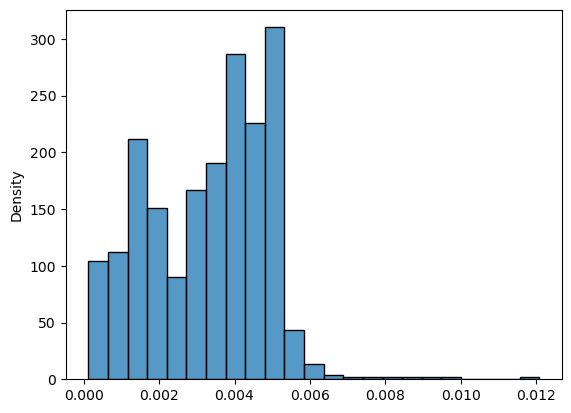

In [185]:
sns.histplot(np.abs(scheduling_errors), stat='density')

In [188]:
import scipy.stats
st.t.interval(confidence=0.99, df=len(scheduling_errors)-1, loc=np.mean(scheduling_errors), scale=st.sem(scheduling_errors)) 

(-0.00343792936292525, -0.0031727461472788304)